## Imports

In [1]:
import numpy as np 
from sklearn.model_selection import RepeatedKFold
import nibabel as nib
from nilearn import plotting
from scipy.io import loadmat, savemat
from importlib import reload
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
from sklearn.model_selection import train_test_split
import os, sys
import numpy as np
import pdb
import argparse
import json 
import subprocess
import pandas as pd
import glob
from scipy.stats import ttest_1samp, ttest_ind, zscore, pearsonr
from statsmodels.stats.multitest import fdrcorrection, multipletests
from mne.stats import fdr_correction
from sklearn.preprocessing import OneHotEncoder
import pickle

In [3]:
import sys
sys.path.insert(1,'../../tfxst/vision_transformers/')



/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

filepath = '/data/users2/ibatta/data/features/SFNC/CSZ/CSZ_new.mat'


In [ ]:
import mat73
data = mat73.loadmat(filepath)

In [ ]:
savemat(filepath, data)


In [ ]:
d = loadmat(filepath)

In [ ]:
d['analysis_subjlist_finished'] == data['analysis_subjlist_finished']

In [ ]:
d['sFNC'].shape

In [ ]:
np.array(data['analysis_subjlist_finished']) == np.array(d['analysis_subjlist_finished'])

In [ ]:
import pandas as pd
import numpy as np

d = pd.read_csv('/data/users2/ibatta/projects/deepsubspace/in/analysis_SCORE_SMRI_relP_imputed.csv')

In [ ]:
d

In [ ]:
d['age'].values.mean(), d['age'].values.std(), d['age'].values.min(), d['age'].values.max()

In [ ]:
d['MMSE'].values.mean(), d['MMSE'].values.std(), d['MMSE'].values.min(), d['MMSE'].values.max()

In [ ]:
(d['labels3way'] == 1).sum(), (d['labels3way'] == 2).sum(), (d['labels3way'] == 3).sum()

In [ ]:
import h5py

def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()
    


In [ ]:
data = read_matlab(filepath)

In [ ]:

data = {}
with h5py.File(filepath) as f:
    for k,v in f.items():
        data[k] = v


In [ ]:
import hdf5storage

data = hdf5storage.loadmat(filepath)
data.keys()

In [ ]:
data['sFNC'].shape

In [ ]:
data['analysis_subjlist_finished']

In [ ]:
[(k,len(v)) for k,v in d.items()]



In [ ]:
d['analysis_subjlist_finished'][]

In [ ]:
salvrs = 'sal_gmr_fwhm20,sal_gmr_fwhm12,sal_gmr_fwhm5,sal_gmr_absol_fwhm20,sal_gmr_absol_fwhm12,sal_gmr_absol_fwhm5'.split(',')

In [ ]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

## Visualize Saliency

In [ ]:
import nibabel as nib
import utils as ut
import numpy as np
import os
import glob



In [ ]:
def loadbin(binfile):
    data = np.fromfile(binfile)
    dshape = np.fromfile(os.path.splitext(binfile)[0] + '.shp', dtype=int)
    data = data.reshape(dshape)
    return data

def savebin(data, binfile):
    data.tofile(binfile)
    np.array(data.shape).tofile(os.path.splitext(binfile)[0] + '.shp')

def bin2niimap(binfile, masks):
    cursal = loadbin(binfile)
    nsub, nv = cursal.shape
    nch, nx, ny, nz = masks.shape
    
    smap = np.zeros([nsub, nch, nx, ny, nz])
    smap[:,0,(masks[0] == 1)] = cursal
    smap =  np.moveaxis(smap.squeeze(axis=1),0,-1)
    
    return smap
    

In [ ]:
basedir = '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_age_iter_110_nc_1_rep_0_bs_32_lr_0.001_espat_40_sf_4/'
# basedir = '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4/'


cfg = ut.loadCfg(basedir + 'config.pkl')
masks = ut.loadMasks(cfg)
maskObj = ut.loadMasks(cfg, nibObjectsOnly=True)
nch, nx, ny, nz = masks.shape


varname = 'sal12gmr'
md = 'te'

In [ ]:
for fname in glob.glob(basedir + 'filters/sal12*.bin'):
# fname = basedir + '/%sReshaped_%s.bin'%(varname,md)
    # cursal = np.fromfile(fname)
    # cursalshape = np.fromfile(os.path.splitext(fname)[0] + '.shp', dtype=int)
    # cursal = cursal.reshape(cursalshape)

    # nsub, nv = cursal.shape
    print(fname)
    smap = bin2niimap(fname, masks)
    # Save first 10 subject maps for checking
    fp, ext = os.path.splitext(fname)
    nib.save(nib.Nifti1Image(smap[:,:,:,:10], affine=maskObj[0].affine, header=maskObj[0].header), fp+'_1to10.nii' )
    


## ICA on Subspaces

In [4]:
import utils as ut
import pickle 
import numpy as np 
import nibabel as nib 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import zscore 

from nilearn.plotting import plot_stat_map
from nilearn import image

import os

from learning import scale_data

In [49]:
nreps = 10

md = 'te'
varnames = 'sal12,sal12absol,sal12gmrabsol,sal12gmr'.split(',')

basedirs = {'age':'../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_age_iter_110_nc_1_rep_0_bs_32_lr_0.001_espat_40_sf_4/',
'MMSE' : '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4/'}


targetvars = ['age','MMSE']

varname = 'sal_gmr_fwhm12'
targetvar = 'MMSE'
basedir = basedirs[targetvar]

cfg = ut.loadCfg(basedir + '/config.pkl')

nc_pca, nc_ica = 1000, 10


### Summarize Correlations

In [50]:
# def summarize_gica(basedir, md, varname, targetvar, nc_pca=100, nc_ica=10):
# # def summarize_gica(basedir, md, varname, targetvar, nc_pca=100, nc_ica=10):

outdir =  basedir + '/groupICA/pca_%d_ica_%d/'%(nc_pca, nc_ica)

## Load target variables and class labels
print('Loading class variables..')

labels = {'age':[],'MMSE':[],'dx':[]}
cls = []

for i in range(nreps):
    curbasedir = basedir.replace('iter_110','iter_11%d'%i).replace('rep_0','rep_%d'%i)
    fname = curbasedir + 'labels_%s.txt'%md
    labels[targetvar].append(np.loadtxt(fname, delimiter=','))
    cfg = ut.loadCfg(curbasedir + 'config_test.pkl')
    df = ut.readFramesSeparately(cfg.sm, cfg.ssd, md, i)
    cls.append(df['labels3way'])
    
labels[targetvar] = np.hstack(labels[targetvar])
cls = np.hstack(cls).squeeze()



Loading class variables..


In [51]:
(cls == 1).sum(), (cls == 2).sum(), (cls == 3).sum(), len(cls)

(468, 332, 933, 1733)

In [52]:


# Load computed gica results
print('Loading computed gICA results..')

gpca_comp_fname = outdir  + '%s_%s_groupPCAEigenVectors.pkl'%(varname,md)
with open(gpca_comp_fname, 'rb') as f:
    gpca_components = pickle.load(f)
gpca_loadings_fname = outdir + '%s_%s_groupPCAloadings.pkl'%(varname,md)
with open(gpca_loadings_fname, 'rb') as f:
    gpca_loadings = pickle.load(f)
gpca_evr_fname = outdir + '%s_%s_groupPCAExplainedVarianceRatio.pkl'%(varname,md)
with open(gpca_evr_fname, 'rb') as f:
    gpca_evr = pickle.load(f)

# gica_comp_fname = basedir + '%s_%s_groupICAcomponents.pkl'%(varname,md)
# with open(gica_comp_fname, 'rb') as f:
#     gica_components = pickle.load(f)
gica_loadings_fname = outdir + '%s_%s_groupICAloadings.pkl'%(varname,md)
with open(gica_loadings_fname, 'rb') as f:
    gica_loadings = pickle.load(f)
    
with open(outdir + '%s_%s_groupICAreconComponents.pkl'%(varname,md),'rb') as f:
    recon_components = pickle.load(f)



Loading computed gICA results..


In [23]:
p10f = basedir + '/groupICA/pca_10_ica_10/' + '%s_%s_groupICAcomponents.pkl'%(varname,md)
with open(p10f,'rb') as pf: 
    p10 = pickle.load(pf)
    # p10 = zscore(p10, axis=1)
p30f = basedir + '/groupICA/pca_30_ica_10/' + '%s_%s_groupICAcomponents.pkl'%(varname,md)
with open(p30f,'rb') as pf: 
    p30 = pickle.load(pf)
    # p30 = zscore(p30, axis=1)


In [24]:
p10.shape, p30.shape

((10, 10), (30, 10))

In [27]:
np.linalg.norm( np.abs(p10[:10,:]) - np.abs(p30[:10,:]), ord=1)

0.0006197714272400472

In [30]:
p30.max(axis=1)

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([8.50823292e-05, 6.15347495e-05, 1.27908590e-04, 1.13563926e-04,
       9.06541019e-05, 6.10090720e-05, 1.13266820e-04, 8.78761391e-05,
       1.02935649e-04, 2.77927518e-05, 2.49034902e-19, 1.43859578e-20,
       2.30410349e-20, 1.01986852e-19, 2.56892892e-20, 5.33020626e-19,
       6.52842871e-20, 1.45876979e-20, 3.35791973e-20, 5.55977696e-21,
       2.86817105e-20, 1.55830539e-20, 1.97017651e-20, 4.81975759e-20,
       1.42277330e-19, 2.83645374e-20, 3.39528319e-21, 4.63396877e-20,
       8.76141238e-21, 7.50593673e-21])

In [53]:

# Scaling of results 
print('Standardizing results..')

# recon_components = zscore(recon_components, axis=0)
# gica_loadings = scale_data(gica_loadings.T, scaling='zscore').T
# gpca_loadings = scale_data(gpca_loadings.T, scaling='zscore').T

recon_components = zscore(recon_components, axis=0)
gica_loadings = zscore(gica_loadings, axis=1)
gpca_loadings = zscore(gpca_loadings, axis=1)

Standardizing results..


In [45]:
recon_components.shape, gica_loadings.shape, gpca_components.shape

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((476991, 10), (10, 1733), (476991, 100))

### PCA Explained variance

In [54]:
gpca_evr.shape

(1000,)

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


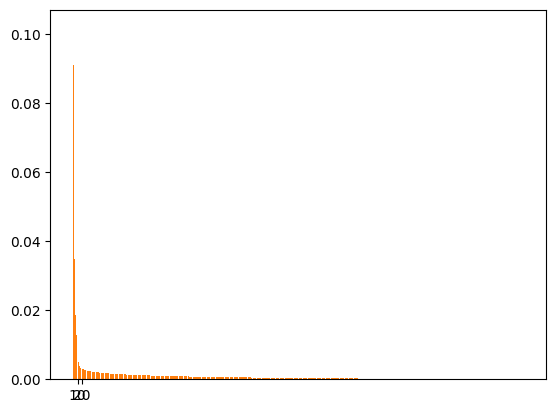

In [56]:
plt.bar([str(i) for i in range(1000)], gpca_evr)
plt.xticks([10,20])
plt.show()

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


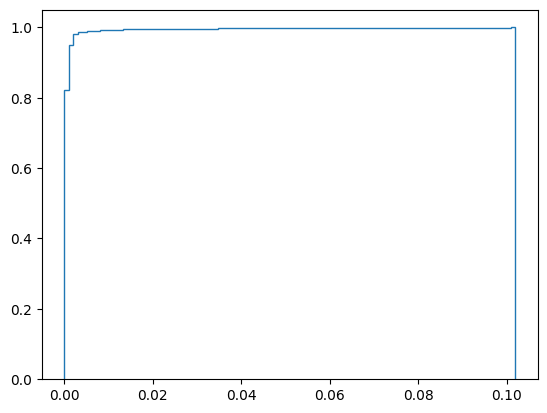

In [57]:
plt.hist(gpca_evr, cumulative=True, density=True, histtype='step', bins=100)
plt.show()

In [ ]:
vthresh = 0.9
xdata = np.arange(1,len(gpca_evr)+1)
ydata = np.cumsum(gpca_evr) / gpca_evr.sum()
plt.plot(xdata, ydata, c='blue', label='EVR-CDF')
plt.plot(xdata, [vthresh for i in xdata], c='r', linestyle='--', label='vthresh')
plt.title('Total EVR=%.3f'%gpca_evr.sum(), c='gray')
plt.legend(loc='lower right')
plt.show()

In [ ]:
gpca_evr.sum()

In [ ]:
gpca_loadings.shape, gica_loadings.shape, labels[targetvar].shape, cls.shape

In [58]:
evr_files = np.sort( glob.glob(basedir + '/groupICA/pca_*_*ica_10/%s_%s*groupPCAExplainedVarianceRatio.pkl'%(varname,md)) )

In [59]:
np.sort(evr_files)

array(['../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4//groupICA/pca_1000_ica_10/sal_gmr_fwhm12_te_groupPCAExplainedVarianceRatio.pkl',
       '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4//groupICA/pca_100_ica_10/sal_gmr_fwhm12_te_groupPCAExplainedVarianceRatio.pkl',
       '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4//groupICA/pca_10_ica_10/sal_gmr_fwhm12_te_groupPCAExplainedVarianceRatio.pkl',
       '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4//groupICA/pca_30_ica_10/sal_gmr_fwhm12_te_groupPCAExplainedVarianceRatio.pkl',
       '../out/results/ADNIt1/mt_AN3DdrhrMx_fkey_hT1_scorename_MMSE_iter_110_nc_1_rep_0_bs_32_lr_0.01_espat_60_sf_4//groupICA/pca_500_ica_10/sal_gmr_fwhm12_te_groupPCAExplainedVarianceRatio.pkl'],
      dtype='<U186')

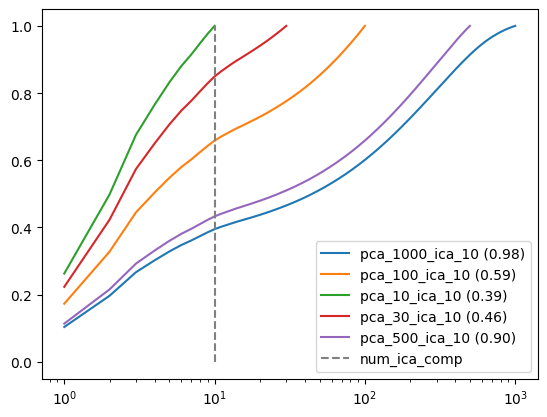

In [62]:
vthresh = 0.9
f, ax = plt.subplots()
pca_ords = [10,30,100,500,1000]
for fi in range(len(evr_files)):
    curfile = evr_files[fi]
    with open(curfile,'rb') as fh:
        cur_gpca_evr = pickle.load(fh)    
    fh.close()
    xdata = np.arange(1,len(cur_gpca_evr)+1)
    ydata = np.cumsum(cur_gpca_evr) / cur_gpca_evr.sum()

    
    cursum = cur_gpca_evr.sum()
    curlabel = curfile.split('/')[-2] + ' (%.2f)'%cursum
    plt.plot(xdata, ydata, label=curlabel)


# ax.plot(xdata, [vthresh for i in xdata], c='r', linestyle='--', label='vthresh')
ax.plot([10,10], [0,1], c='gray', linestyle='--', label='num_ica_comp')
ax.legend(loc='lower right')
plt.xscale('log')
plt.show()
plt.close(f)

### Prediction using loadings. 

In [63]:
# Prediction using loadings.
import sys
sys.path.insert(-1,'../../subspace/code/')
from learning import compute_predictions_tuned

from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid
from sklearn.svm import SVR, SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, auc, precision_score, recall_score
from scipy.stats import pearsonr

In [64]:
clf_scores = {i:i for i in ['accuracy_score', 'auc', 'precision_score', 'recall_score']}
reg_scores = {i:i for i in ['neg_mean_absolute_error','r2']}


In [ ]:
sklearn.metrics.SCORERS.keys()

In [65]:
params =ParameterGrid({'alpha':[[0.0001,0.001,0.01,0.1,1,10,20,50,75,100,150,200,500,1000]]})#, 'gamma':[[0.1,1,10]]})#, 'kernel': [[ 'rbf']] })
# params =ParameterGrid({'C':[[0.001,0.01,0.1,1,10,100]], 'gamma':[[0.1,1,10]], 'kernel': [[ 'rbf']] })


In [66]:

gsresult = GridSearchCV(estimator=Ridge(), n_jobs=16, param_grid=params, cv=10, scoring=reg_scores, refit='neg_mean_absolute_error').fit(gica_loadings.T, labels[targetvar])


In [67]:
gsresult.cv_results_.keys()

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'split5_test_neg_mean_absolute_error', 'split6_test_neg_mean_absolute_error', 'split7_test_neg_mean_absolute_error', 'split8_test_neg_mean_absolute_error', 'split9_test_neg_mean_absolute_error', 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'])

In [68]:
gsresult.cv_results_['mean_test_neg_mean_absolute_error'], gsresult.cv_results_['std_test_neg_mean_absolute_error']


(array([-3.31967078, -3.31963838, -3.31931454, -3.31608371, -3.28463658,
        -3.0388389 , -2.86356525, -2.58367061, -2.46445152, -2.39432142,
        -2.32079797, -2.28749886, -2.24334445, -2.24362072]),
 array([0.98998474, 0.98996326, 0.98974853, 0.98760659, 0.96679011,
        0.80021642, 0.66686475, 0.41903877, 0.30561481, 0.24185468,
        0.176481  , 0.14841492, 0.12485519, 0.11649726]))

In [69]:
gsresult.cv_results_['mean_test_r2'], gsresult.cv_results_['std_test_r2']

(array([-1.02408089, -1.02404365, -1.02367138, -1.01996155, -0.98411074,
        -0.71765127, -0.53734443, -0.27460888, -0.17582462, -0.11818988,
        -0.055881  , -0.02414071,  0.02696289,  0.03559206]),
 array([0.90770538, 0.90767843, 0.90740902, 0.90472481, 0.87882849,
        0.6857963 , 0.54956405, 0.33112861, 0.23972333, 0.18345833,
        0.12028017, 0.08748547, 0.03518054, 0.02392693]))

In [76]:
gpca_loadings.shape

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1000, 1733)

In [83]:
## USING PCA LOADINGS


# params =ParameterGrid({'C':[[0.1,1, 10]], 'gamma':[[0.1,1,10]], 'kernel': [[ 'rbf']] })
gsresult = GridSearchCV(estimator=Ridge(), n_jobs=16, param_grid=params, cv=10, scoring=reg_scores, refit='neg_mean_absolute_error').fit(gpca_loadings[:10].T, labels[targetvar])


In [84]:
gsresult.cv_results_['mean_test_neg_mean_absolute_error'], gsresult.cv_results_['mean_test_r2']

/data/users2/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([-3.31967078, -3.31963838, -3.31931454, -3.31608371, -3.28463658,
        -3.0388389 , -2.86356525, -2.58367061, -2.46445152, -2.39432142,
        -2.32079797, -2.28749886, -2.24334445, -2.24362072]),
 array([-1.02408089, -1.02404365, -1.02367138, -1.01996155, -0.98411074,
        -0.71765127, -0.53734443, -0.27460888, -0.17582462, -0.11818988,
        -0.055881  , -0.02414071,  0.02696289,  0.03559206]))

In [72]:
np.where(gsresult.cv_results_['rank_test_neg_mean_absolute_error']==1)

(array([13]),)

In [85]:
gsresult.best_score_, gsresult.best_params_

(-2.2433444452553504, {'alpha': 500})

In [74]:
gsresult.best_estimator_.coef_.shape

(1000,)

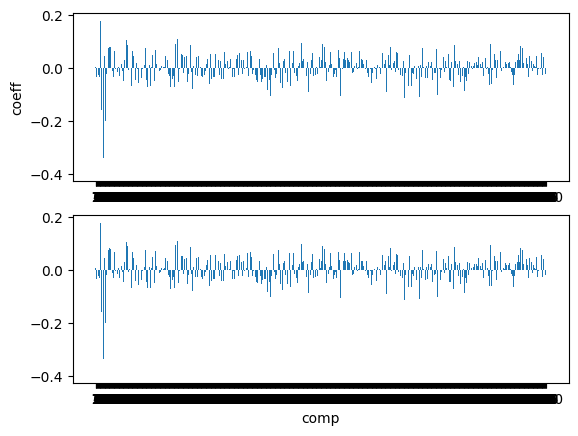

In [75]:
f, ax = plt.subplots(nrows=2, ncols=1)
coeffs = gsresult.best_estimator_.coef_
barlabels = [str(i+1) for i in range(len(coeffs))]
bar0 = ax[0].bar(barlabels, coeffs)
bar1 = ax[1].bar(barlabels, coeffs)
plt.xlabel('comp')
ax[0].set_ylabel('coeff')
plt.show()
plt.close(f)

### Correlation of target vars 

In [ ]:

# Correlation of target vars
print('Performing correlation analysis with target variables..')
comp_corrs = np.corrcoef(labels[targetvar].squeeze(), gica_loadings)
label_corrs = comp_corrs[0][1:] # Skipping the first entry because that's self-correlation of labels (r=1)



besti = np.abs(label_corrs).argsort()[-1]

### Group ICA Results Summary on Saliency Maps

f, ax = plt.subplots()
barlabels = ['c%d'%(i+1) for i in range(len(label_corrs))]
bar = ax.bar(barlabels, label_corrs, label=label_corrs)
ax.bar_label(bar, labels=['%.2f'%li for li in  label_corrs], fontsize=9)
ax.set_xticklabels(barlabels, rotation=90)
plt.title('Correlation between gICA component loadings and target label (%s)'%targetvar + '\n(pca_%d_ica_%d; %s_%s)'%(nc_pca, nc_ica, varname, md))
plt.xlabel('gICA components')
plt.ylabel('Correlation with %s'%targetvar)
plt.show()
# plt.savefig(outdir + '%s_%s_loadingsCorr.png'%(varname,md))
plt.close()


In [ ]:


## PLot best correlation

# plt.scatter(labels[targetvar].squeeze(), gica_loadings[besti,:])
f, ax = plt.subplots()
sns.regplot(gica_loadings[besti,:], labels[targetvar].squeeze(), scatter_kws={'color':'gray'},line_kws={'color':'blue'}, robust=False)
plt.xlabel('Loadings from component %d'%(besti+1))
plt.ylabel(targetvar)
plt.title('Plot for component loadings with highest correlation with target variable')
plt.savefig(outdir + '%s_%s_bestComponentCorr.png'%(varname,md))
plt.close()



### Group Comparison of loadings
print('Perfroming group comparison of gICA loadings..')

## Group comparison of gPCA loadings
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True)
f.suptitle('Group comparison of gPCA loadings')
for ci in range(gica_loadings.shape[0]):
    
    ax[ci // 5, ci % 5].boxplot([gpca_loadings[ci,cls==1], gpca_loadings[ci,cls==2], gpca_loadings[ci,cls==3]], labels=['CN','AD','MCI'])
    ax[ci // 5, ci % 5].set_title('Component %d'%(ci+1))
    

plt.savefig(outdir + '%s_%s_gPCAgroupComparison.png'%(varname,md))
plt.close()


## Group comparison of gICA loadings
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True)
f.suptitle('Group comparison of gICA loadings')
for ci in range(gica_loadings.shape[0]):
    
    ax[ci // 5, ci % 5].boxplot([gica_loadings[ci,cls==1], gica_loadings[ci,cls==2], gica_loadings[ci,cls==3]], labels=['CN','AD','MCI'])
    ax[ci // 5, ci % 5].set_title('Component %d'%(ci+1))
    

plt.savefig(outdir + '%s_%s_gICAgroupComparison.png'%(varname,md))
plt.close()




### Save Group ICA maps 
print('Saving gICA component maps as nii..')

nsub, nc = recon_components.shape

cfg = ut.loadCfg(basedir + 'config.pkl')
masks = ut.loadMasks(cfg)
maskObj = ut.loadMasks(cfg, nibObjectsOnly=True)
nch, nx, ny, nz = masks.shape

mr = masks.reshape(nch, nx*ny*nz)
curout = np.zeros([nc, nx*ny*nz])
for ci in range(nc):
    curout[ci,mr[0]==1] = recon_components[:,ci]

curout =  np.moveaxis(curout.reshape([nc,nx,ny,nz]), 0, -1)




gica_outfile = outdir + '%s_%s_groupICAreconComponents_zscored.nii'%(varname,md)
gica_nimg = nib.Nifti1Image(curout, affine=maskObj[0].affine, header=maskObj[0].header )
nib.save(gica_nimg, gica_outfile)




In [ ]:


### Plot Group ICA maps 
print('Plotting gICA maps..')




gica_file = outdir + '%s_%s_groupICAreconComponents_zscored.nii'%(varname,md)
gica_img = image.load_img(nib.load(gica_file))

nx, ny, nz, nvol = gica_img.shape
rowcoldict = {10:(4,3), 30:(6,5), 100:(10,10), 5:(3,2)}
nrows, ncols = rowcoldict[nvol]
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*4,ncols*4), facecolor='black')

axcover = np.zeros([nrows,ncols], dtype=bool)

for vol in range(nvol):
    rw, col = vol // ncols, vol % ncols
    # if vol == 9:
    #     col += 1

    plot_stat_map(image.index_img(gica_img, vol), threshold=1, black_bg=True, title='C%d'%(vol+1), figure=f, axes=ax[rw,col])
    axcover[rw,col] = True
    
# ax[-1,0].axis('off')
# ax[-1,-1].axis('off')
for rw,col in zip(np.where(axcover==False)[0], np.where(axcover==False)[1]):
    ax[rw,col].axis('off')
    ax[rw,col].axis('off')

f.suptitle('Components from gICA on saliency maps (pca_%d_ica_%d; %s_%s)'%(nc_pca, nc_ica, varname, md), color='white')
# plt.savefig(os.path.splitext(gica_file)[0] + '_ortho.png')
# plt.close(f)
plt.show()
plt.close(f)

In [ ]:
plt.close()

In [ ]:
plot_stat_map(image.index_img(gica_img, vol), threshold=1, black_bg=True, title='C%d'%(vol+1))

In [ ]:
plt.show()

In [ ]:
from summarize_gica import summarize_gica

In [ ]:
summarize_gica(basedirs['age'], md, varname, 'age', nc_pca=100, nc_ica=10)

In [ ]:
with open(basedirs['age']+ '/groupICA/sal12gmrabsol_te_groupPCAExplainedVarianceRatio.pkl','rb') as f:
    evr = pickle.load(f)


In [ ]:
plt.close(f)

In [ ]:

f, ax = plt.subplots()
plt.bar(list(range(1,101)), evr)
plt.show()

In [ ]:
evr[evr > 0.05]

In [ ]:
evr

In [ ]:


for tvar in targetvars:
    basedir = basedirs[tvar]
    # for salname in varnames:
    for salname in ['sal12gmr','sal12gmrabsol']:
        print(tvar + ',' + salname)
        
        summarize_gica(basedir, md, salname, tvar)
        



In [ ]:
[1,2] + [1,3]

In [ ]:
plt.show()

### Prediction using loadings

## Summarize Connected Subspaces (indiviudal blind ICA)

### Load subspace data

In [ ]:
nreps =10
C_all = [] # voxel - PCA components
PCAl_all = [] # PCA loadings
A_all = [] # PCA - ICA mixing components 
S_all = [] # voxel - ICA composite components.

for i in range(nreps):
    basedir = basedir.replace('iter_110','iter_11%d'%i).replace('rep_0','rep_%d'%i)
    fname = basedir + '/fsal_tr_standardPCAEigenVectors.pkl'
    with open(fname, 'rb') as f:
        C = pickle.load(f)
    C_all.append(C)
    lfname = basedir + '/fsal_tr_standardPCAloadings.pkl'
    with open(lfname, 'rb') as f: 
        PCAl = pickle.load(f)
    PCAl_all.append(PCAl)
    # C = np.loadtxt(, delimiter=',')
    ica_fname = basedir + '/fsal_tr_ICAcomponents.pkl'
    with open(ica_fname, 'rb') as f:
        A = pickle.load(f)
    A_all.append(A) # Rows of A are PCA components and columns are ICA components. 
    S = C @ A 
    S_all.append(S)

    dim, nc = C.shape
C_all = np.hstack(C_all)
A_all = np.hstack(A_all)
S_all = np.hstack(S_all)
PCAl_all = np.hstack(PCAl_all)

# group_ica_comp, group_ica_loadings = ut.compute_subspaces(PCAl_all, procedure='fastICA', n_components=10,return_transform=True, normalize='zscore') 

In [ ]:
ICAcorr = np.corrcoef(S_all.T)
PCAcorr =  np.corrcoef(C_all.T)


In [ ]:
PCAcorr.shape

In [ ]:
sns.heatmap(PCAcorr[:100,:100])

In [ ]:
plt.show()

In [ ]:
def select_matching_subspaces(Corr, corrThresh = 0.4):
    Corr -= np.eye(Corr.shape[0])
    assert np.all(Corr - Corr.T < 1e-8)
    # maxi = np.abs(Corr).max(axis=0)[:,np.newaxis]
    G = nx.from_numpy_matrix(np.abs(Corr) > corrThresh, create_using = nx.MultiGraph())
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    return [list(si.nodes) for si in S if len((si))>1] # Return connected components based on thresholded correlation matrix.



In [ ]:
ms = select_matching_subspaces(ICAcorr, corrThresh=0.4) 

In [ ]:
ms

### Save all subspaces across reps

In [ ]:

cfg = ut.loadCfg(basedir + 'config.pkl')
masks = ut.loadMasks(cfg)
maskObj = ut.loadMasks(cfg, nibObjectsOnly=True)
nch, nx, ny, nz = masks.shape

mr = masks.reshape(nch, nx*ny*nz)
curout = np.zeros([nc*nreps, nx*ny*nz])
for ci in range(nc*nreps):
    curout[ci,mr[0]==1] = S_all[:,ci]

curout =  np.moveaxis(curout.reshape([nc*nreps,nx,ny,nz]), 0, -1)
nib.save(nib.Nifti1Image(curout, affine=maskObj[0].affine, header=maskObj[0].header ), basedir+'fsal_tr_ICAcomponents_allreps.nii')

In [ ]:
basedir

In [ ]:
ms

In [ ]:
S_all.max()

In [ ]:
PCAcorr =  np.corrcoef(C_all.T)
PCAcorr -= np.eye(PCAcorr.shape[0])


In [ ]:
np.all(PCAcorr - PCAcorr.T < 1e-8)

In [ ]:
sns.heatmap(PCAcorr, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [ ]:
maxi = np.abs(PCAcorr).max(axis=0)[:,np.newaxis]
sns.heatmap(maxi, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [ ]:
maxi.squeeze()

In [ ]:
i = 0
j = 2
sns.heatmap(PCAcorr[nreps*i:nreps*(i+1),nreps*j:nreps*(j+1)], vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f')

In [ ]:
plt.show()

In [ ]:
corrThresh = 0.4
np.where(np.abs(np.tril(PCAcorr, -1) > corrThresh))

In [ ]:
mr.shape

In [ ]:
import numpy as np 
import nibabel as nib 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [ ]:
import numpy as np 
import nibabel as nib 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
a = np.random.random([4,4])

In [ ]:
False

In [ ]:
np.unravel_index(a.argmax(), a.shape)

In [ ]:
ix = np.unravel_index(np.argsort(-a, axis=None), a.shape)

In [ ]:
ix

In [ ]:
ix[0][0], ix[1][0
                ]

## Match Components HCP-UKB

In [ ]:
import numpy as np 
import nibabel as nib 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

indir = '/data/neuromark2/Results/ICA_template_str/'
cmp1 = nib.load(indir + 'UKB/High100_sm12/UKB_highorder_100_sm12_group_component_ica_.nii')
mask1 = nib.load(indir + 'UKB/High100_sm12/UKB_highorder_100_sm12Mask.nii').get_fdata()
cmp2 = nib.load(indir + 'HCP/High100_sm12/HCP_highorder_100_sm12_group_component_ica_.nii')
mask2 = nib.load(indir + 'HCP/High100_sm12/HCP_highorder_100_sm12Mask.nii').get_fdata()
outdir = '/data/users2/ibatta/data/phenotype/SMRI_components/ICA_template_str2/'
outfile_prefix = 'UKB_HCP_High100_sm12'

d1 = cmp1.get_fdata()
d2 = cmp2.get_fdata()
assert d1.shape == d2.shape

xdim, ydim, zdim, nc = d1.shape


In [ ]:

# use intersection mask
d1_flat = d1[(mask1*mask2)!=0,:]
d2_flat = d2[(mask1*mask2)!=0,:]



# Compute correlation between each pair of components
Cmat = np.corrcoef(d1_flat.T, d2_flat.T, rowvar=True)
Ca = np.abs(Cmat[:nc, nc:])
Sca = np.sign(Cmat[:nc, nc:])

# Use Greedy Matching to find the best matching component pairs between datasets
out = pd.DataFrame(columns=['UKB','HCP','r','sign']).astype({'HCP':'int32', 'UKB':'int32', 'r':'float64', 'sign':'int8'})
sorted_indices = np.unravel_index(np.argsort(-Ca, axis=None), Ca.shape)

for i in range(nc**2):
# while True:
#     if len(out.index) == nc:
#         break 
    max_i, max_j = sorted_indices[0][i], sorted_indices[1][i]
    if not((1+max_i in out['UKB'].values) or (1+max_j in out['HCP'].values)):
        out = out.append({'UKB':1+max_i, 'HCP':1+max_j, 'r':Ca[max_i,max_j], 'sign':Sca[max_i,max_j] }, ignore_index=True)
        
    # tc = np.argsort(-Ca[i,:]) # top components with respect to absolute pearson correlation 
    # bi = 0 # index of highest correlated component in second dataset as per greedy match
    # while tc[bi] in out['HCP'].values:
    #     bi += 1
    # out = out.append({'UKB':int(i), 'HCP':int(tc[bi]), 'r':Ca[i,tc[bi]], 'sign':Sca[i,tc[bi]] }, ignore_index=True)
out.to_excel(outdir + outfile_prefix + '_matchTable.xlsx', index=False)

# Plot and save matching correlations
f, ax = plt.subplots()
sns.heatmap(Sca * Ca, cmap='vlag', vmin=-1, vmax=1)
plt.xlabel('HCP component id') # Columns
plt.ylabel('UKB component id') # Rows
plt.savefig(outdir + outfile_prefix + '_matchCorr.png')
plt.close(f)
np.savetxt(outdir + outfile_prefix + '_matchCorr.csv', Sca*Ca, delimiter=',')



In [ ]:
len(sorted_indices[0])

In [ ]:
stats = nib.load('../out/saliency_stats/mt_AN3DdrlrMx_fkey_lT1_scorename_age_iter_X_nc_2_rep_X_bs_32_lr_0.0001_espat_20/tstats_fsal_raw_meansal_meansal.nii.gz')

In [ ]:
d = nib.load('/data/users2/ibatta/data/features/lowresSMRI/ADNI/random_subject.nii.gz')

In [ ]:
plotting.plot_img(stats, cmap='coolwarm', colorbar=True, vmin=-1e-4, vmax=1e-4, threshold=1e-5, black_bg=True, bg_img=d)
plt.show()

In [ ]:
hist, bins = np.histogram(d,bins=1000)
plt.plot(hist, bins)
plt.show()


In [ ]:
plt.hist(d[d>0.03].flatten(), bins=100)
plt.show()

In [ ]:
np.sum(d>0)

In [ ]:
fp = '../out/results/latest/mt_AN3DdrlrMxG_fkey_lT1_scorename_labels_3way_iter_208_nc_3_rep_9_bs_32_lr_0.0001_espat_20/sal_zscore.pkl'

In [ ]:
with open(fp,'rb') as f:
    d = pickle.load(f)

In [ ]:
d.shape

## Visualize Fusion Layer Features and Gradients.

In [ ]:
d = []
dG = []
eig = []
eigG = []
eigGS = []
eigICA = []
# basepath = '/data/users2/ibatta/projects/deepsubspace/out/results/optimized/mt_BrASLnet2_fkey_lT1_scorename_labels_3way_iter_100_nc_2_rep_0_bs_8_lr_0.0001619311091244073_espat_20_sf_4/'
basepath = '/data/users2/ibatta/projects/deepsubspace/out/results/ADNIt1/mt_BrASLnet5_fkey_lT1_scorename_MMSE_iter_100_nc_1_rep_0_bs_32_lr_0.01_espat_20_sf_4/'

for i in range(100,110):
    d.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + '/ifeat_tr.csv',delimiter=','))
    dG.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + 'isal_tr.csv',delimiter=','))
    # eig.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + 'ifeat_tr_SparseEigenVectors.csv',delimiter=','))
    # eigG.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + 'isal_tr_EigenVectors.csv',delimiter=','))
    # eigGS.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + 'isal_tr_SparseEigenVectors.csv',delimiter=','))
    # eigICA.append(np.loadtxt(basepath.replace('iter_100','iter_'+str(i)).replace('rep_0','rep_%d'%(i-100)) + 'isal_tr_fastICAEigenVectors.csv',delimiter=','))
d = np.vstack(d)
dG = np.vstack(dG)
# eig = np.vstack(eig)
# eigG = np.vstack(eigG)
# eigGS = np.vstack(eigGS)
# eigICA = np.vstack(eigICA)


In [ ]:
d.shape, dG.shape

In [ ]:
nreps = 10
nrep0 = int(d.shape[0] / nreps)

In [ ]:
sns.boxplot(data = dG[:nrep0], fliersize=0.1)
plt.show()

In [ ]:
sns.boxplot(data = d[:nrep0], fliersize=0.1)
plt.show()

In [ ]:
dGC = np.cov(dG[:nrep0].T)

In [ ]:
sns.heatmap(dG)
plt.show()

In [ ]:
ns = nrep0
f, ax = plt.subplots(2,1)
sns.boxplot(data=d[:ns], fliersize=0.1, ax=ax[0], hue=None)
ax[0].plot([0,d.shape[1]], [0,0], 'k-' )

# ax[0].set_aspect(0.75)
sns.boxplot(data=dG[:ns], fliersize=0.1, ax=ax[1], hue=None)
ax[1].plot([0,dG.shape[1]], [0,0], 'k-' )

# ax[1].set_aspect(0.75)

ax[0].set_xticklabels(np.arange(d.shape[1])+1, rotation=45, fontsize=5)
ax[0].set_ylabel('Fusion Layer Feature')
ax[1].set_xticklabels(np.arange(dG.shape[1])+1, rotation=45, fontsize=5)
ax[1].set_ylabel('Fusion Layer Gradient')
ax[1].set_xlabel('intermediate feature index (branch number)')




plt.show()




In [ ]:
f, ax = plt.subplots(2,1)
sns.boxplot(data=d[296:(296*2)], fliersize=0.1, ax=ax[0], hue=None)
sns.boxplot(data=dG[296:(296*2)], fliersize=0.1, ax=ax[1], hue=None)
ax[0].set_aspect(0.75)
ax[1].set_aspect(0.75)

plt.show()
plt.close(f)

In [ ]:
f, ax = plt.subplots()
sns.boxplot(data=d[296:592], fliersize=0.1, ax=ax)
ax.set_aspect(0.75)
plt.show()
plt.close(f)

In [ ]:
sns.heatmap(eig)
plt.show()

In [ ]:
sns.heatmap(eigICA)
plt.show()

## Deep ASL

In [ ]:
# import pickle 

# isalfile = '/data/users2/ibatta/projects/deepsubspace/out/results/optimized/mt_BrASLnet2_fkey_lT1_scorename_labels_3way_iter_109_nc_2_rep_9_bs_8_lr_0.0001619311091244073_espat_20_sf_4/isal_zscore.pkl'

# with open(isalfile, 'rb') as f:
#     isal = pickle.load(f)


In [ ]:
import sys
sys.path.insert(1,'../../subspace/code/')
import glob 


In [ ]:
from cluster_summaries import create_rep_summaries

for scr in ['MMSE']:
    for fs in ['','Sparse','Augmented','AugmentedSparse']:
    # for fs in ['Augmented']:
        print(scr + ',' + fs)
        
        wfiles = glob.glob('../out/subspace_matrices/ADNI/PSVRASL/all_lT1_%s_BrASLnet5_r*_%sEigenVectors.csv'%(scr,fs))
        gfiles = glob.glob('../out/predictions/ADNI/all_lT1_%s_PSVR_BrASLnet5_r*_%sgradients.csv'%(scr,fs.replace('Sparse','')))

        # if scr == 'MMSE':
        #     wfiles = glob.glob('../out/results/threshmask/mt_BrASLnet5_fkey_lT1_scorename_MMSE_iter_*_nc_1_rep_*_bs_32_lr_0.01_espat_20_sf_4/isal_tr_%sEigenVectors.csv'%fs)
        #     gfiles = glob.glob('../out/results/threshmask/mt_BrASLnet5_fkey_lT1_scorename_MMSE_iter_*_nc_1_rep_*_bs_32_lr_0.01_espat_20_sf_4/isal_tr.csv')
        # elif scr == 'age':
        #     wfiles = glob.glob('../out/results/threshmask/mt_BrASLnet5_fkey_lT1_scorename_age_iter_*_nc_1_rep_*_bs_16_lr_0.01_espat_20_sf_16/isal_tr_%sEigenVectors.csv'%fs)
        #     gfiles = glob.glob('../out/results/threshmask/mt_BrASLnet5_fkey_lT1_scorename_age_iter_*_nc_1_rep_*_bs_16_lr_0.01_espat_20_sf_16/isal_tr.csv')
        # # wfiles = glob.glob('../out/results/optimized/mt_BrASLnet2_fkey_lT1_scorename_labels_3way_iter_*_nc_2_rep_*_bs_8_lr_0.0001619311091244073_espat_20_sf_4/isal_tr_fastICAEigenVectors.csv')
        # # gfiles = glob.glob('../out/results/optimized/mt_BrASLnet2_fkey_lT1_scorename_labels_3way_iter_*_nc_2_rep_*_bs_8_lr_0.0001619311091244073_espat_20_sf_4/isal_tr.csv')
        
        woutfile = '../out/subspace_matrices/ADNI/PSVRASL/lT1_%s_BrASLnet5_%sEigenVectors_top100.mat'%(scr,fs)
        goutfile = '../out/predictions/ADNI/lT1_%s_PSVR_BrASLnet5_%sgradients_top.mat'%(scr,fs.replace('Sparse',''))

        create_rep_summaries('ADNI', 'PSVRASL', 'lT1', scr, fs, 'BrASLnet5', filelist=wfiles, gfilelist=gfiles, foutfilename=woutfile, goutfilename=goutfile, nreps=10)

In [ ]:
from cluster_summaries import cluster_summaries

# for scr in ['age','MMSE']:
for scr in ['MMSE']:
    # for fs in ['','Augmented']:
    for fs in ['','Augmented','AugmentedSparse','Sparse']:
        print(scr + ',' + fs)
        cluster_summaries('ADNI','PSVRASL','all','lT1',scr,'BrASLnet5',fs, te=20, mode='EigenVectorsAligned')

In [ ]:
from learn_subspaces import compute_subspaces

In [ ]:
dw = loadmat('../out/subspace_matrices/ADNI/DeepASL/lT1_age_BrASLnet2Opt2_fastICAEigenVectors_top100.mat')

In [ ]:
f, ax = plt.subplots(3,3)
for i in range(9):
    print('%d,%d,%d'%(i,np.min(dw['W'][0][0][0][i]), np.max(dw['W'][0][0][0][i])))
    # print(np.unique(dw['W'][0][0][0][i]))
    print(np.trace(dw['W'][0][0][0][i]))
    sns.heatmap(dw['W'][0][0][0][i], ax=ax[i//3,i%3])

plt.show()


In [ ]:
sns.heatmap(dw['W'][0][0][0][0], cmap='PiYG')
plt.show()

In [ ]:
from scipy.io import loadmat, savemat

In [ ]:
L = loadmat('../out/subspace_matrices/ADNI/DeepASL/lT1_age_BrASLnet2_Lambda_top100.mat')

In [ ]:
G = loadmat('../out/predictions/ADNI/lT1_age_Deep_BrASLnet2_gradients_top.mat')

In [ ]:
G['Gcloud']

In [ ]:
L['L'][0,0][0].sum()

In [ ]:
W = loadmat('../out/subspace_matrices/ADNI/DeepASL/lT1_nc2_BrASLnet2_EigenVectors_top100.mat')

In [ ]:
W['W'][0][0][0].shape

In [ ]:
L, W, C = compute_subspaces(isal.T)

In [ ]:
import utils as ut 

cg = ut.loadCfg('../out/results/raytune/mt_AN3DdrlrMx_fkey_fMVP_scorename_age_iter_110_nc_1_rep_0_bs_32_lr_0.0014297724879798386_espat_40_sf_4/best_config.pkl')



In [ ]:
cg

In [ ]:
cg2 = ut.updateIterML(cg)

In [ ]:
cg2

## MVP Feature Extraction 

In [ ]:
import pandas as pd 
import numpy as np 
import os 
import glob
import nibabel as nib

In [ ]:
ica_dir = '/data/qneuromark/Data/ADNI/Updated/fMRI/Results/GIGICA/'
scores_file = '../in/analysis_SCORE_MMR180d.csv'


In [ ]:
dinfo = pd.read_csv(scores_file)

In [ ]:
pthe = np.array([os.path.exists(ica_dir+pth) for pth in dinfo['lowres_fmriPath']])


In [ ]:
labels = np.loadtxt('../in/labels_3way_MMR180d.txt', dtype=int)

In [ ]:
labels[~pthe] = 1000 

In [ ]:
np.savetxt('../in/labels_3way_MMR180d_mvp.txt', labels, fmt='%d')

In [ ]:
pth = dinfo['lowres_fmriPath'][pthe][0]

In [ ]:
fl = ica_dir + pth + '/swarest1/adni_aa__sub01_component_ica_s1_.nii'

In [ ]:
d = nib.load(fl).get_fdata()

In [ ]:
d.max(axis=-1).shape

In [ ]:
cd = d[:,:,:,cmpi].max(axis=-1).shape

In [ ]:
d[:,:,:,cmpi].argmax(axis=-1).shape

In [ ]:
outdir = '/data/users2/ibatta/data/features/fmrimeasures/ADNI/nii/'
cmpi = np.loadtxt('/data/users2/ibatta/data/features/SFNC/good_component_indices.txt',dtype=int)

for pth in dinfo['lowres_fmriPath'][pthe]:
    # print(pth)
    # dirs = glob.glob(ica_dir+pth+'/*')
    # fl = np.sort(dirs)[0] + '/adni_aa__sub01_component_ica_s1_.nii'
    fl = ica_dir + pth + '/swarest1/adni_aa__sub01_component_ica_s1_.nii'
    print(fl)
    components = nib.load(fl)
    cdata = components.get_fdata()
    
    os.makedirs(outdir+pth, exist_ok=True)
    
    mvpabs = np.abs(cdata[:,:,:,cmpi]).max(axis=-1)
    
    outfile_mvp = outdir + pth + '/swarest1_mvp.nii'
    mvp = cdata[:,:,:,cmpi].max(axis=-1)
    print('absmax vs max:')
    print((mvpabs - mvp).sum())
    
    continue 

    nib.save(nib.Nifti1Image(mvp, affine=components.affine, header=components.header), outfile_mvp)
    
    outfile_mvpi = outdir + pth + '/swarest1_mvp_indices.nii'
    mvpi = cdata[:,:,:,cmpi].argmax(axis=-1)
    nib.save(nib.Nifti1Image(mvpi, affine=components.affine, header=components.header), outfile_mvpi)
    
    # if len(dirs) > 1:
    #     print(len(dirs))
    #     if not 'swarest1' in np.sort(dirs)[0]:
    #         print(np.sort(dirs)[0])
    #     print('-----------')
    # folders = [di.split('/')[-1] for di in dirs]
    
    # if len(dirs) > 1:
    #     print(dirs)    

## FDR Correction

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.datasets import sample
from mne.stats import bonferroni_correction, fdr_correction

print(__doc__)

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np


# Creating dataset
np.random.seed(10)
data = np.random.normal(100, 20, 200)

fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(data, showmeans=True)
plt.scatter([1],[data.mean()], label='mean')
# plt.scatter([1],[np.median(data)], label='median')
plt.legend()

# show plot
plt.show()


In [ ]:
a = np.zeros([2,3])

In [ ]:
a.mean(axis=0)

In [ ]:
np.expand_dims(np.array([[1,2]])[0],1).shape

In [ ]:
np.expand_dims(np.array([[1,2]])[0],0)

## ROI-Voxel Intersection

In [ ]:
import numpy as np 
import nibabel as nib 
import pandas as pd 
import glob

def compute_roi_stats(inputfile, atlasfile, thresh, fracThresh=0.9, absMode=True, datavolnames=None, roinames=None):
    """_summary_

    Args:
        inputfile (str): path to nii file with input data. nii files with multiple volumes can also be handled. 
        atlasfile (str): path to nii file with masked ROIs, containing ROI mask in each volume.
    """
    
    data = nib.load(inputfile).get_fdata()
    atlas = nib.load(atlasfile).get_fdata()
    
    assert np.all(data.shape[:3] == atlas.shape[:3])
    nx, ny, nz, nch = data.shape
    _, _, _, nr = atlas.shape
    
    if (datavolnames == None):
        datavolnames = [str(i) for i in range(nch)]
    
    if (np.any(roinames) == None):
        roinames = [str(i) for i in range(nr)]
    roinames = np.array(roinames)
    
    out_data = {}
    names = np.array(roinames)
    indices = np.array(list(range(nr)))
    out_vars = ['names','indices',
                'frac_active','indicators_active_f','sorted_indices_f','sorted_fracs','sorted_indicators_f','sorted_names_f',
                'mean_vox','indicators_active_m','sorted_indices_m','sorted_means','sorted_indicators_m','sorted_names_m']
        
    for ch in range(nch):
        
        masked_data = atlas * data[:,:,:,ch:(ch+1)]
        total_vox = atlas.sum(axis=(0,1,2))
        
        if absMode:
            significant_voxels = np.abs(masked_data) > thresh
        else:
            significant_voxels = (masked_data > thresh)
            
        signs_vox = np.sign(masked_data) * significant_voxels

        nnz_vox = (significant_voxels).sum(axis=(0,1,2))    
        sign_active = np.sign(signs_vox.sum(axis=(0,1,2)))
        sign_active =  np.sign(sign_active + 0.5*(nnz_vox > 0)) # assign positive sign if equal number of positive and negative voxels
        
        # Calculate mean based on whether most voxels are positive or negative.
        mean_vox_pos = ((signs_vox==1)*masked_data*significant_voxels).sum(axis=(0,1,2)) / total_vox
        mean_vox_neg = ((signs_vox==-1)*masked_data*significant_voxels).sum(axis=(0,1,2)) / total_vox    
        mean_vox = mean_vox_pos*(sign_active==1) + np.abs(mean_vox_neg*(sign_active == -1)) #abs value
        mean_vox *= sign_active
        indicators_active_m = np.abs(mean_vox) > thresh
        sorted_indices_m = np.argsort(np.abs(mean_vox))[::-1] # Descending order sorted indices
        sorted_means = mean_vox[sorted_indices_m]
        sorted_indicators_m = indicators_active_m[sorted_indices_m]
        sorted_names_m = roinames[sorted_indices_m]
        
        frac_active = (nnz_vox / total_vox)
        indicators_active_f = frac_active > fracThresh
        sorted_indices_f = np.argsort(frac_active)[::-1] # Descending order sorted indices
        frac_active *= sign_active
        sorted_fracs = frac_active[sorted_indices_f]
        sorted_indicators_f = indicators_active_f[sorted_indices_f]
        sorted_names_f = roinames[sorted_indices_f]
        
        out_data[ch] = {}
        for vi in out_vars:
            out_data[ch][vi] = eval(vi)
        
    return out_data
        


def write_roi_stats(inputfile, atlasfile):
        
    atlas_info = pd.read_csv('../../../data/atlases/HO-CortSubcortCB-ROIs.csv')
    roinames = atlas_info['shortname'].values

    
    cs = inputfile.split('/')[-2].split('_')
    fkeys = cs[cs.index('fkey')+1].split(',')
    statmode = inputfile.split('/')[-1].split('_')[3]
    assert statmode in ['single','groupwise','univsmul','intrabim']     
    
    threshold = 1.3

    out_data = compute_roi_stats(inputfile, atlasfile, threshold, roinames=roinames)    


    outfile = inputfile.replace('.nii','.csv').replace('.gz','')
    outf = open(outfile,'w+')

    for fi in range(len(fkeys)):
        fkey = fkeys[fi]
        if statmode == 'intrabim' and fi > 0:
            break
        elif statmode == 'intrabim' and fi == 0:
            fkey = '-'.join(fkeys)
        for vi in out_data[fi].keys():
            vector_vals = [str(i) for i in out_data[fi][vi]]
            if vi in ['mean_vox','sorted_means','frac_active','sorted_fracs']:
                vector_vals = ['%.2f'%i for i in out_data[fi][vi]]
            line = ','.join( ['-'.join(fkeys),statmode,fkey,vi] + vector_vals )
            outf.write( line + '\n' )
    outf.close()

In [ ]:
atlasfile = '../../../data/atlases/ROImaskvols_T1lowres/rlowres_HO-CortSubcortCB-atlas-ROImasks_MaskedBinarized.nii.gz'
for fi in glob.glob('../out/saliency_stats/*MVP*/tstats_fsal_zscore_*_minusSignTlogP_fdrCorrected.nii.gz'):
    print(fi)
    write_roi_stats(fi,atlasfile)

### Reformat 

In [ ]:


# inpath = '../out/salient_regions/groupwise_mean_v1.3.xlsx'

for inpath in glob.glob('../out/salient_regions/*v1.3.xlsx'):
    print(inpath)

    d = pd.read_excel(inpath, header=None)

    outdf = pd.DataFrame({'index':[i for i in range(len(d[1].values))]})
    for i in d.columns:
        if i % 2 == 1:
            continue
        coldata = ['%s (%s)'%(d[i+1].values[j],d[i].values[j])  for j in range(len(d[i].values))]
        
        outdf[i] = coldata
    outdf.to_excel(inpath.replace('.xlsx','_reformatted.xlsx'), header=False, index=False,)
        

## Data Characteristics

In [ ]:
data = pd.read_csv('../in/analysis_SCORE_MMR180d.csv')
data = data[data.labels_3way != 3]

In [ ]:
data['age'].mean(), data['age'].std()

In [ ]:
(data['Sex'] == 'Male').sum(), (data['Sex'] == 'Female').sum()

In [ ]:
(fracs > 0.9)

## Smallest Enclosing Cuboid

In [ ]:
import numpy as np 
import nibabel as nib



def get_cuboid_corners(indices):
    """_summary_

    Args:
        indices (np array): shape 4,ni where ni is the number of non-zero voxels. 
                            indices[-3] should represent the coordinates of non-zero voxels, 
                            indices[-1] should represent the corresponding volume number (roi number)
    """
    nr = np.sort(np.unique(indices[-1]))

    imin, imax = [],[]
    for roi in nr:
        curi = (indices[-1] == roi)
        imin.append(indices[:3,curi].min(axis=1))
        imax.append(indices[:3,curi].max(axis=1))

    imin, imax = np.vstack(imin), np.vstack(imax)    
    largest_dims = (imax-imin).max(axis=0) # Dimensions of required cuboid 
    
    return imin, imax


def computed_adjusted_cuboid_corners(indices):
    imin, imax = get_cuboid_corners(indices)
    dims = imax - imin
    largest_dims = dims.max(axis=0) # Dimensions of required cuboid 
    newmin = imax - largest_dims
    newmax = imax
    newmax[newmin < 0] += np.abs(newmin[newmin < 0])
    newmin[newmin<0] += np.abs(newmin[newmin < 0])

    assert np.all(newmax - newmin == largest_dims)
    
    return newmin, newmax


def smallest_enclosing_cuboid(inputfilepath, indices_outfile, cuboids_outfile, return_output=False, adjusted=True):
    print('Loading Data..')
    atlas_im = nib.load(inputfilepath)
    atlas = np.array(atlas_im.get_fdata(), dtype=bool)
    nx, ny, nz, nr = atlas.shape
    print(atlas.shape)

    indices = np.array(np.where(atlas==1), dtype=int)
    
    print('Computing Cuboid Corners..')
    if adjusted:
        imin, imax = computed_adjusted_cuboid_corners(indices)
    else: 
        imin, imax = get_cuboid_corners(indices)
    
    assert( (imin.shape[0] == nr) and (imax.shape[0]==nr) )
    assert( (imin.shape[1] == 3) and (imax.shape[1]==3) )
    
    print('Saving Results..')
    out_data = np.zeros(atlas.shape, dtype=int)
    for roi in range(nr):
        out_data[imin[roi,0]:imax[roi,0]+1,imin[roi,1]:imax[roi,1]+1,imin[roi,2]:imax[roi,2]+1, roi] = 1
    
    header = 'xmin,ymin,zmin,xmax,ymax,zmax'
    np.savetxt(indices_outfile,np.hstack((imin,imax)),fmt='%d',header=header, delimiter=',')
    
    nib.save(nib.Nifti1Image(out_data,header=atlas_im.header,affine=atlas_im.affine), cuboids_outfile)
    
    if return_output:
        return imin, imax, out_data
    
    

In [ ]:
atlasfile = '/data/users2/ibatta/data/atlases/ROImaskvols_T1lowres/rlowres_HO-CortSubcortCB-atlas-ROImasks_MaskedBinarized.nii.gz'
indices_outfile = '/data/users2/ibatta/data/atlases/ROImaskvols_T1lowres/rlowres_HO-CortSubcortCB-atlas-ROImasks_MaskedBinarized_adjustedCuboids_indices.csv'
cuboids_outfile = '/data/users2/ibatta/data/atlases/ROImaskvols_T1lowres/rlowres_HO-CortSubcortCB-atlas-ROImasks_MaskedBinarized_adjustedCuboids.nii.gz'

In [ ]:
imin, imax, out_data = smallest_enclosing_cuboid(atlasfile,indices_outfile, cuboids_outfile, return_output=True, adjusted=True)

In [ ]:
a = np.array(       [[37, 15, 30],
       [31, 18, 14],
       [20, 23, 21],
       [37, 15, 17],
       [40,  8, 12],
       [41,  7, 12],
       [44, 17, 26],
       [42,  9, 18],
       [44,  6, 10],
       [47, 10, 10],
       [45,  6, 11],
       [48, 13, 13],
       [46, 10, 11],
       [41,  6,  8],
       [45, 13, 12],
       [45, 10, 10],
       [46, 16, 23],
       [30,  9, 12],
       [45,  9, 12],
       [46,  8, 17],
       [43,  7, 15],
       [39, 13, 21],
       [40, 13, 14],
       [18, 12,  9],
       [10, 10, 11],
       [10, 10, 12],
       [10, 10, 12],
       [12, 18, 25],
       [11, 22, 21],
       [15, 16, 19],
       [19, 17, 23],
       [17,  9, 10],
       [36, 13, 12],
       [25, 12, 10],
       [23,  8, 11],
       [23, 20, 11],
       [29,  7,  8],
       [32, 13, 14],
       [33, 10, 10],
       [32, 12,  8],
       [34,  9,  9],
       [44, 13, 11],
       [44,  8,  9],
       [42, 11, 11],
       [40,  9,  8],
       [46, 13, 10],
       [18, 12,  7],
       [25,  7, 20],
       [11, 31, 11],
       [10, 15,  8],
       [ 6, 14, 12],
       [ 8, 14, 10],
       [ 7,  9,  6],
       [16, 15, 24],
       [11, 14, 13],
       [ 8,  8,  8],
       [ 4,  6,  5],
       [12, 30, 12],
       [ 9, 15,  9],
       [ 6, 13, 12],
       [ 8, 15, 10],
       [ 7,  9,  5],
       [10, 14, 13],
       [ 8,  8,  8],
       [ 5,  6,  5],
       [ 9, 12, 14],
       [10, 11, 15],
       [15, 19, 16],
       [17, 18, 16],
       [ 5,  8,  9],
       [18, 19, 15],
       [ 5,  4,  6],
       [18, 18, 14],
       [16, 17, 14],
       [ 7, 12,  9],
       [18, 16, 14]])

In [ ]:
( (a.prod(axis=1) > 4096) & ((a>=16).sum(axis=1)<3) )

In [ ]:
np.sort(a.sum(axis=1))

In [ ]:
( (a.prod(axis=1) > 2048) & ((a>=8).sum(axis=1)==3) )


In [ ]:
import numpy as np 

In [ ]:
fes = np.loadtxt('../in/feature_extractor_out_shapes.txt', delimiter=',')

In [ ]:
fes // 16

In [ ]:
c = [(0, 768), (1, 576), (2, 288), (3, 768), (4, 288), (5, 480), (6, 432), (7, 768), (8, 192), (9, 64), (10, 512), (11, 576), (12, 128), (13, 576), (14, 384), (15, 64), (16, 576), (17, 384), (18, 512), (19, 576), (20, 960), (21, 576), (22, 432), (23, 512), (24, 32), (25, 32), (26, 32), (27, 384), (28, 288), (29, 768), (30, 576), (31, 192), (32, 384), (33, 96), (34, 288), (35, 192), (36, 960), (37, 432), (38, 48), (39, 288), (40, 768), (41, 288), (42, 576), (43, 192), (44, 576), (45, 192), (46, 640), (47, 480), (48, 192), (49, 192), (50, 384), (51, 144), (52, 1280), (53, 576), (54, 288), (55, 432), (56, 384), (57, 192), (58, 1024), (59, 384), (60, 192), (61, 960), (62, 144), (63, 432), (64, 576), (65, 384), (66, 128), (67, 768), (68, 576), (69, 576), (70, 1024), (71, 384), (72, 768), (73, 432), (74, 640), (75, 576)]

In [ ]:
b = np.array([2240, 2304, 1152, 896, 145920, 124800, 4096, 1728, 86016, 640, 99072, 2560, 640, 59904, 1280, 640, 1728, 384, 640, 253440, 170560, 1344, 2048, 71680, 36864, 40960, 40960, 960, 1024, 768, 2304, 53760, 896, 320, 72576, 768, 51840, 1536, 448, 115200, 448, 1152, 112896, 576, 102144, 1280, 51200, 132480, 384, 39936, 30720, 36864, 8960, 1024, 76032, 13824, 1536, 384, 40768, 28160, 39936, 6720, 67584, 13824, 2304, 53760, 59904, 768, 1152, 8064, 1152, 1536, 1152, 768, 22400, 768])

In [ ]:
((a>8).sum(axis=1)==3).sum()


In [ ]:
(a.prod(axis=1) > 8092).sum()

In [ ]:
(a.prod(axis=1) > 4096).sum()

In [ ]:
roi=50
out_data[imin[roi,0]:imax[roi,0],imin[roi,1]:imax[roi,1],imin[roi,2]:imax[roi,2], roi].shape

In [ ]:
a = np.loadtxt(indices_outfile,delimiter=',')

In [ ]:
a[0]

In [ ]:
newdims

In [ ]:
np.all()

In [ ]:
def make_cuboid_inplace(newmin, imax):
    x1,y1=newmin.shape
    x2,y2 =imax.shape
    assert np.all([y1==3, y2==3])
    assert(x1==x2)
    
    
        

In [ ]:
newmin

In [ ]:
(imax - imin).max(axis=0)

In [ ]:
def compute_enclosing_cuboid()

## Prep Atlases

### Combine Harvard-Oxford atlases for cortical and sub-cortical regions

In [ ]:
basepath = '/sysapps/ubuntu-applications/fsl/6.0.5.2/fsl/data/atlases/'

subcort = nib.load(basepath + 'HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
subcort_data = np.array(subcort.get_fdata(), dtype=int)
subcort_names = pd.read_csv('../../../data/atlases/HO-Subcort-ROIs.csv')
cort = nib.load(basepath + 'HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz')
cort_names = pd.read_csv('../../../data/atlases/HO-Cort-ROIs.csv')
cb = nib.load(basepath + 'Cerebellum/Cerebellum-MNIflirt-maxprob-thr25-1mm.nii.gz')
cb_data = np.array(cb.get_fdata(), dtype=int)
cb_names = pd.read_csv('../../../data/atlases/HO-CB-ROIs.csv')
# cb_data[cb_data>0] = 1 # Binarize, as CB is needed as one region
out_names = pd.DataFrame([],columns=cort_names.columns)
out_names = out_names.append(cort_names, ignore_index=True)
out_data = np.array(cort.get_fdata(), dtype=int)
# c1 = np.array([[i,(out_data==i).sum()] for i in np.unique(out_data) if i!=0 ])
# print(-np.sort(-c1[:,1]))
# c2 = np.array([[i,(subcort_data==i).sum()] for i in np.unique(subcort_data) if i!=0])
# print(-np.sort(-c2[:,1]))
# c3 = np.array([[i,(cb_data==i).sum()] for i in np.unique(cb_data) if i!=0])
# print(-np.sort(-c3[:,1]))
# Replace label numbers for subcortical data to append to cortical
offset = 48 # There are 0-47 labels in cortical regions
remove_indices = np.array([0,1,11,12])
for li in range(21):
    if li in remove_indices:
        print('Skipping %d'%li)
        continue
    out_data[subcort_data==(li+1)] = li+1+offset
    
# Remove cortical and white matter voxels from subcortical map
remove_values = remove_indices + 1 + offset
# remove_voxels = np.zeros(subcort_data.shape, dtype=bool)
adder = 0
new_map = {}
for v in range(1+offset,70):
    if v in remove_values:
        adder += 1
        out_data[out_data==v] = 0
        print('%d,%s will be removed'%(v, subcort_names['name'][v-offset-1]))
    else:
        print('Replacing %d,%s with %d,%s'%
              (v-adder,subcort_names['name'][v-offset-1-adder], v,subcort_names['name'][v-offset-1]))
        out_data[out_data==v] = v - adder
        names_row = {ci:subcort_names.iloc[v-offset-1][ci] for ci in subcort_names.columns}
        names_row['index'] = v - adder - 1
        out_names = out_names.append(names_row, ignore_index=True)
        new_map[v-1] = v-1 - adder  # -1 because of indices
    # remove_voxels = np.logical_or(remove_voxels, out_data == rv)
# out_data[np.where(remove_voxels==True)] = 0
# Add Cerbellar Regions with new indices for some of the combined regions.
cboffset = len(out_names)
new_cb_map = {}
for i in range(27):
    li = cb_names.iloc[i]['newindex']
    out_data[cb_data == i+1] = li+1 + cboffset
    
    if not li+cboffset in out_names['index']:
        ignore_cols = ['newindex','newname','newshortname']
        names_row = {ci:cb_names.iloc[i][ci] for ci in cb_names.columns if ci not in ignore_cols}
        names_row['index'] = cb_names.iloc[i]['newindex'] + cboffset
        names_row['shortname'] = cb_names.iloc[i]['newshortname']
        names_row['name'] = cb_names.iloc[i]['newname']    
        out_names = out_names.append(names_row, ignore_index=True)
    new_cb_map[i+offset] = i
outpath = '../../../data/atlases/'
nib.save(nib.Nifti1Image(np.array(out_data, dtype=int), affine=cort.affine, header=cort.header), outpath+'HO-CortSubcortCB-atlas.nii.gz')
out_names.to_csv(outpath+'HO-CortSubcortCB-ROIs.csv', index=False)
with open(outpath + 'new_subcort_roi_map.json','w+') as f:
    json.dump(new_map, f)
with open(outpath + 'new_CB_roi_map.json','w+') as f:
    json.dump(new_cb_map, f)

### Generate Mask for each ROI

In [ ]:
nx,ny,nz = out_data.shape
nm = np.unique(out_data).max()
out_masks = []

for i in range(nm):
    curmask = np.zeros(out_data.shape, dtype=int)
    curmask[out_data==(i+1)] = i+1
    out_masks.append(curmask)
out_masks = np.array(out_masks,dtype=int)
out_masks = np.moveaxis(out_masks, 0, -1)

In [ ]:
nib.save(nib.Nifti1Image(np.array(out_masks, dtype=int), affine=cort.affine, header=cort.header), outpath+'HO-CortSubcortCB-atlas-ROImasks.nii.gz')

## Saliency

In [ ]:
import utils as ut 
import summarize as smr
from models import AN3Ddr_lowresMax
import torch
from torch.autograd import Variable
from scipy.ndimage import gaussian_filter

In [ ]:
a = nib.load('/data/users2/ibatta/data/features/lowresSMRI/ADNI/random_subject.nii.gz')

In [ ]:
b = np.zeros(a.get_fdata().shape)

In [ ]:
nib.save(nib.Nifti1Image(b, affine=a.affine, header=a.header), 'check_nibsave.nii')

In [ ]:
saltype = 'fsal_raw'
basedir = '../out/results/latest/'
config_string = 'mt_AN3DdrlrMx_fkey_lT1_scorename_xyz_iter_*_nc_2_rep_*_bs_32_lr_0.0001_espat_20' 
configlist_file = '../in/config_keys/allcombos_baseline_clf_nc2'
files_key = basedir + config_string + '/' + saltype + '.pkl'

In [ ]:
import summarize as smr 

In [ ]:
smr.summarize_all_saliencies(configlist_file, 'labels_3way',10,-1)

In [ ]:
smr.summarize_all_saliencies(configlist_file, 'labels_3way',10,0)

In [ ]:
outfile = '../out/saliency_stats/' + config_string.replace('*','X') + '/tstats.nii.gz'

In [ ]:
smr.summarize_saliency(config_string, 'labels_3way',outfile, saltype=saltype)

In [ ]:
cfgpath = glob.glob(basedir + config_string)[0] + '/config.pkl' 
cfg = ut.loadCfg(cfgpath)
masks = ut.loadMasks(cfg)

In [ ]:
def load_masked_saliency_maps(config_string, masks, saltype, normalize=True):
    """
    Loads saliency maps from all the files in the mentioned config string into a single list of length nch

    Args:
        config_string (str): keywords to be used as configuration string to search from models outputs directory
        
        
    """

    basedir = '../out/results/latest/'
    
    nch, nx, ny, nz = masks.shape
    mr = masks.reshape([nch,nx*ny*nz])
    
    out_data = [[] for ch in range(nch)]
    for salfile in glob.glob(basedir+config_string+'/'+saltype+'.pkl'):
        with open (salfile, 'rb') as f:
            sal_data = pickle.load(f)
        assert np.all(sal_data.shape[1:] == masks.shape)
        nsub, _, _, _, _ = sal_data.shape
        sal_data = sal_data.reshape([nsub,nch,nx*ny*nz])
        for ch in range(nch):
            out_data[ch].append(sal_data[:,ch,mr[ch]==1])
    for ch in range(nch):
        out_data[ch] = np.vstack(out_data[ch])
        if normalize:
            out_data[ch] = ut.normalize_image(out_data[ch], method='zscore', axis=1)
        
    return out_data        



In [ ]:
md = load_masked_saliency_maps(config_string, masks, saltype, normalize=False)

In [ ]:
mdc = [md[i][0] for i in range(len(md))]

In [ ]:
mdc[0].shape , mdc[1].shape

In [ ]:
mdc = [ut.normalize_image(mdc[i]) for i in range(len(mdc))]

In [ ]:
from scipy.stats import zscore

In [ ]:
b = np.array([[ 0.3148,  0.0478,  0.6243,  0.4608],
              [ 0.7149,  0.0775,  0.6072,  0.9656],
              [ 0.6341,  0.1403,  0.9759,  0.4064],
              [ 0.5918,  0.6948,  0.904 ,  0.3721],
              [ 0.0921,  0.2481,  0.1188,  0.1366]])

In [ ]:
b.shape

In [ ]:
b.mean(axis=1)

In [ ]:
zscore(b, axis=1).mean(axis=1)

In [ ]:
c = np.array([b,b])

In [ ]:
c.shape

In [ ]:
zscore(c, axis=2).mean(axis=2)

In [ ]:

def save_masked_maps(data, masks, outfilepath):
    # mask is a 4-D np array with shape (nch, nx, ny, nz)
    # data is a list (and not np.array!) of vectors, each with different length depending on non-zero voxels of the corresponding mask
    # outfilepath should be a path with .nii or .nii.gz as extension.
    
    nch, nx, ny, nz = masks.shape
    assert len(data) == nch
    mr = masks.reshape(nch, nx*ny*nz)
    
    cur_out = np.zeros([nch, nx*ny*nz])
    for ch in range(nch): 
        cur_out[ch,mr[ch]==1] = data[ch]
    
    cur_out =  np.moveaxis(cur_out.reshape([nch,nx,ny,nz]), 0, -1)
    nib.save(nib.Nifti1Image(cur_out, np.eye(4)), outfilepath)


In [ ]:
save_masked_maps(mdc, masks, '../out/check_save.nii')

In [ ]:
print(files_key)

In [ ]:
maskfile = "/data/users2/ibatta/data/masks/ADNI/ADNI_T1_lowres.nii.gz"
mask = nib.load(maskfile).get_fdata()

In [ ]:
mr = mask.reshape(np.prod(mask.shape))

In [ ]:
salfile = glob.glob(basedir+config_string+'/'+saltype+'.pkl')[0]
with open(salfile, 'rb') as f:
    sal_data = pickle.load(f)
sal_data = ut.normalize_5D(np.abs(sal_data), method='zscore')
n, nch, nx, ny, nz = sal_data.shape
print(sal_data.shape)


In [ ]:
zscore(sal_data[0,0], axis=None).mean()

In [ ]:
sal_data[0,1].mean()

In [ ]:
sd = sal_data.reshape([n, nch, nx*ny*nz])[:,0]

In [ ]:
sd.shape

In [ ]:
sd[:,mr==1].shape

In [ ]:
t, p = ttest_1samp((sd[:,mr==1]), 0, axis=0)

In [ ]:
sal_data.shape

In [ ]:
sal_data[:,0].shape

In [ ]:
t.shape, p.shape

In [ ]:
nch*nx*ny*nz

In [ ]:
p.min(), p.max()

In [ ]:
# out  = multipletests(p.reshape([nch*nx*ny*nz]), method='fdr_bh')
out  = multipletests(p, method='fdr_bh')

In [ ]:
cd = plt.hist(pc,bins=100, density=True, cumulative=False, histtype='stepfilled')

In [ ]:
# (rej, pc) = fdrcorrection(p.reshape([nch*nx*ny*nz]))
(rej, pc) = fdrcorrection(p)


In [ ]:
pc.shape

In [ ]:
a = np.zeros([nx*ny*nz])

In [ ]:
a[mr==1] = pc

In [ ]:
a = a.reshape([1,nx,ny,nz])

In [ ]:

nib.save(nib.Nifti1Image(a, np.eye(4)), 
             'check.nii')

In [ ]:
pc.min(), pc.max()

In [ ]:
np.max(pc)

In [ ]:
sal_data.mean()

In [ ]:
np.max(sal_data), np.min(sal_data)

In [ ]:
(rej, pc) = fdr_correction(p.reshape([nch*nx*ny*nz]))


In [ ]:

rej = rej.reshape([nch,nx,ny,nz])
pc = pc.reshape([nch,nx,ny,nz])

In [ ]:
pc[rej==True][-10:], p[rej==True][-10:]

In [ ]:
(np.isnan(p)).sum()


In [ ]:
(rej==False).sum()

In [ ]:
fp = '/data/users2/ibatta/projects/deepsubspace/out/results/mt_AN3DdrlrMx_fkey_lT1_scorename_labels_3way_iter_10_nc_2_rep_0_bs_32_lr_0.0001_espat_20/fimsal.pkl'
with open(fp,'rb') as f:
    sal = pickle.load(f)


In [ ]:
sal.shape

In [ ]:
def myminmax(X, axis=0):
    return X*np.sum(X)

c = np.apply_over_axes(myminmax, a, [0,1])

In [ ]:
sal = np.moveaxis(sal,0,-1)
nib.save(nib.Nifti1Image(sal[0], np.eye(4)), 'test.nii')

In [ ]:
c[0,0,0,0,0]

In [ ]:
b.shape

In [ ]:
reload(ut)

In [ ]:
mdpath = '../out/modelout/model_state_dict.pt'
cfpath = '../out/modelout/config.pkl'

# model = AN3Ddr_lowresMax(num_classes=2, num_channels=1, num_groups=1)

cfg = ut.loadCfg(cfpath)
cfg.ml = '../out/modelout/'
model = ut.loadNet(cfg)

model.load_state_dict(torch.load(mdpath))
model.eval()


In [ ]:
dataloader = ut.loadData(cfg, 'te')

In [ ]:
for _, data in enumerate(dataloader, 0):
    inputs, labels = data
    break

In [ ]:
inputs.shape

In [ ]:
tempmask = np.ones(inputs.shape[2:])

In [ ]:
tempmask.shape

In [ ]:
inputs = inputs.cpu()
model = model.cpu()
ut.run_saliency('../out/modelout/','BP', inputs, model, tempmask, 'labels_3way','clx')

In [ ]:
a,b,c,d = ut.sensitivity_analysis(model, inputs, tempmask, cuda=False)

In [ ]:
d = '/data/users2/ibatta/data/features/fmrimeasures/ADNI/nii/002_S_6007/Axial_rsfMRI__Eyes_Open_/2017-03-31_10_40_49.0/S551365/rest/'

f1 = nib.load(d+'swarest1_tsavg.nii').get_fdata()
f2 = nib.load(d+'swarest1_ALFF.nii').get_fdata()


In [ ]:
np.prod(f1.shape)

In [ ]:
(f1-f2 > 10).sum()

In [ ]:
f1 = (f1 - f1.min()) / (f1.max()-f1.min())
f2 = (f2 - f2.min()) / (f2.max()-f2.min())


In [ ]:
(f1-f2 > 0.01).sum()

In [ ]:
fl = '/data/qneuromark/Data/ADNI/Updated/fMRI/ADNI/177_S_6335/Axial_MB_rsfMRI__Eyes_Open_/2020-07-22_12_56_01.0/S951207/rest/swarest1.nii'
dl = nib.load(fl).get_fdata()


In [ ]:
basedir='/data/qneuromark/Data/ADNI/Updated/fMRI/Results/GIGICA/041_S_6401/Axial_rsfMRI__Eyes_Open_/2018-06-12_13_51_03.0/S694594/rest/swarest1/'
f1 = 'adni_aa__sub01_component_ica_s1_.nii'
f2 = 'adni_aa__ica_c1-1.mat'



In [ ]:
d1 = nib.load(basedir + f1).get_fdata()

In [ ]:
d2 = loadmat(basedir + f2)

In [ ]:
d2.keys()

In [ ]:
d1.shape

In [ ]:
d2['ic'].shape, d2['tc'].shape

In [ ]:
53*63*52, 66529*194

##  QC 

### Constant Valued Scans

In [ ]:
dataset = 'ADNI'
filemapper = json.load(open('../in/filemapper.json','r'))

measures = list(filemapper['filename']['ADNI'].keys())

nanfiles = []
numnans = []
badfiles = []

for m in measures: 
    basepath_mapper = filemapper['basepathmapper'][dataset][m]
    basedir = filemapper['basedir'][dataset][basepath_mapper]
    # basedir = '/data/qneuromark/Data/ADNI/Updated/fMRI/ADNI/'
    filename = filemapper['filename']['ADNI'][m]
    # filename = 'swarest1.nii'
    for dir in open('../in/%s_MMR180.csv'%basepath_mapper,'r+').read().split('\n')[:-1]:
        fullpath = basedir + dir + filename
        scandata = nib.load(fullpath).get_fdata()
        if np.isnan(scandata).sum() > 0:
            nn = np.isnan(scandata).sum()
            print(nn)
            print(fullpath)
            nanfiles.append(fullpath)
            numnans.append(nn)
        if np.abs(np.std(scandata)) < 0.001:
            print(np.abs(np.std(scandata)))
            print(fullpath)
            badfiles.append(fullpath)




In [ ]:
with open('../in/badfiles_measures.txt','w+') as f:
    f.write('\n'.join(badfiles))

with open('../in/numnans_measures.txt','w+') as f:
    f.write('\n'.join(['%s,%d'%(nanfiles[i],numnans[i]) for i in range(len(nanfiles))]))
    

In [ ]:
len(['ALFF', 'DCw', 'DCb', 'fALFF', 'KccReHo', 'VMHC', 'lT1', 'ALFF,DCw,DCb,fALFF,KccReHo,VMHC,lT1', 'ALFF,lT1', 'DCw,lT1', 'DCb,lT1', 'fALFF,lT1', 'KccReHo,lT1', 'VMHC,lT1'])

### Imputations

In [ ]:
with open('../in/vars.txt', 'r+') as f:
    scores = f.read().split('\n')[:-1]
scores_file = '../in/analysis_SCORE_SMRI_relP.csv'
df = pd.read_csv(scores_file)


In [ ]:
print(df['age'].dtype)

In [ ]:
scores = 'age,Sex,APOE4,FDG,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,MMSE,RAVLT,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ'.split(',')

In [ ]:

for score in scores:
    print('%s, %s'%(score,df[score].dtype))
    dt = df[score].dtype
    if not 'float' in str(dt):
        df[score] = df[score].fillna(df[score].mode())
    else:
        df[score] = df[score].fillna(df[score].median())

df.to_csv('../in/analysis_SCORE_SMRI_relP_imputed.csv',  index=False)

In [ ]:
output_file = '../out/performances/baseline/allcombos_baseline_reg.png '

In [ ]:
pval_file = '.'.join(output_file.split('.')[:-1]) + '_pvals.' + output_file.split('.')[-1]

In [ ]:
fns = ['tsavg','tsmedian','tsmax','tsmin']
    # fns.remove('hT1')
    # fns.remove('PerAF')
    # fns.append(','.join(fns)) #multimodal with all features into DL model
    fns += [fi+',lT1' for fi in fns if 'lT1' not in fi] # multimodal with 2 modalities: with one fmri measure with low-res smri 
    # fns.append(','.join([','.join(fns) for i in range(8)] )) # Testing 56 groups for future  
    print(fns)

    # # Map iter value (slurm taskID) to training sample size (tss) and crossvalidation repetition (rep)
    fv, rv = np.meshgrid(np.arange(len(fns)), np.arange(cfg.nReps))
    fv = fv.reshape((1, np.prod(fv.shape)))
    rv = rv.reshape((1, np.prod(rv.shape)))
    fkey = fns[fv[0][cfg.iter]]
    rep = rv[0][cfg.iter]
    print(fkey, rep)
    cfg.fkey = fkey
    cfg.nch = len(fkey.split(','))
    cfg.rep = rep
    print(cfg.iter, cfg.tss, cfg.rep)


In [ ]:
fm = json.load(open('../in/filemapper.json','r'))

In [ ]:
fns = list(fm['filename']['ADNI'].keys())

In [ ]:
len(fns)

In [ ]:
fns = ['tsavg','tsmedian','tsmax','tsmin']
# fns.remove('hT1')
# fns.remove('PerAF')
# fns.append(','.join(fns)) #multimodal with all features into DL model
fns += [fi+',lT1' for fi in fns if 'lT1' not in fi] # multimodal with 2 modalities: with one fmri measure with low-res smri 

In [ ]:
i = 8
fv, rv, sv = np.meshgrid(np.arange(len(fns)), np.arange(10), np.arange(8))
fv = fv.reshape((1, np.prod(fv.shape)))
rv = rv.reshape((1, np.prod(rv.shape)))
sv = sv.reshape((1, np.prod(sv.shape)))

for i in range(80):
    fkey = fns[fv[0][i]]
    rep = rv[0][i]
    scr = sv[0][i]
    print(fkey, rep, scr)

In [ ]:
fv.shape, rv.shape, sv.shape

In [ ]:
i = 8
fns.remove('hT1')
fns.remove('PerAF')

fv, rv = np.meshgrid(np.arange(len(fns)), np.arange(10))
fv = fv.reshape((1, np.prod(fv.shape)))
rv = rv.reshape((1, np.prod(rv.shape)))

for i in range(80):
    fkey = fns[fv[0][i]]
    rep = rv[0][i]
    
    print(i,fkey, rep)

In [ ]:
def summarize_config(config_string):
    """
    Computes the set of test accuracy for the string corresponding to the config_string. 
    The config strings should represent one of the directory. 
    """

    basedir = '../out/results/latest/'
    cmd = 'cat %s%s/test.csv | grep -v acc_te | cut -f2 -d\",\"'%(basedir,config_string)
    output_stream = os.popen(cmd)
    test_accs = np.array(output_stream.read().split('\n')[:-1], dtype=float)
    return test_accs

In [ ]:
config_string = 'AN3Ddr_lowresMax_fkey_ALFF_scorename_labels_3way_iter_*_nc_2_rep_*_bs_32_lr_1e-05_espat_20'

In [ ]:
t = summarize_config(config_string)

In [ ]:
len(t)

In [ ]:
t = summarize_config('AN3Ddr_lowresMax_fkey_ALFF_scorename_labels_3way_iter_*_nc_2_rep_*_bs_32_lr_1e-05_espat_20')

In [ ]:

n = 30
k_te = 4
k_va = 5
nreps = 3

all_labels = np.array(list(range(0,30)), dtype=int) // 10

# selelct specific labels if needed for binary classification
select_labels = [0,2]
labels = np.array([li for li in all_labels if li in select_labels], dtype=int)
sli = np.array([i for i in range(len(all_labels)) if all_labels[i] in select_labels], dtype=int)


for ri in np.arange(nreps):
	tri, test_indices = train_test_split(np.arange(len(labels)), test_size=1.0/k_te, shuffle=True, stratify=labels, random_state=108+ri)
	tr_idx, val_idx = train_test_split(np.arange(len(tri)), test_size=1/k_va, shuffle=True, stratify=labels[tri], random_state=108+ri)
	train_indices, val_indices = tri[tr_idx], tri[val_idx]

	print(all_labels[sli[train_indices]], all_labels[sli[val_indices]], all_labels[sli[test_indices]])
    


In [ ]:
np.loadtxt('../out/temp1.txt').mean()

In [ ]:
np.loadtxt('../out/temp2.txt').mean()

In [ ]:


	np.savetxt(outdir+'/tr_r'+str(ri)+'.csv', train_indices, fmt='%d')
	np.savetxt(outdir+'/va_r'+str(ri)+'.csv', val_indices, fmt='%d')
	np.savetxt(outdir+'/te_r'+str(ri)+'.csv', test_indices, fmt='%d')



In [ ]:
from sklearn.model_selection import train_test_split

tr, va = train_test_split(np.arange(n), test_size=0.2)

In [ ]:
tr, va

In [ ]:
import pandas as pd 
# Try Merge
fl = '../in/lowresfilelist_ADNI_SMRI.txt'
sm = '../in/analysis_SCORE_SMRI_fpL.csv'

df_fl = pd.read_csv(fl)
df_sm = pd.read_csv(sm).iloc[idx]


In [ ]:
for iter in range(12):
    tv, rv = np.meshgrid([], np.arange(3))
    tv = tv.reshape((1, np.prod(tv.shape)))
    rv = rv.reshape((1, np.prod(tv.shape)))
    tss = tv[0][iter]
    rep = rv[0][iter]
    print(tss, rep)

## Ray Tune

In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

In [ ]:
# DATA LOADERS
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # We add FileLock here because multiple workers will want to
    # download data, and this may cause overwrites since
    # DataLoader is not threadsafe.
    with FileLock(os.path.expanduser("~/.data.lock")):
        trainset = torchvision.datasets.CIFAR10(
            root=data_dir, train=True, download=True, transform=transform)

        testset = torchvision.datasets.CIFAR10(
            root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_cifar(config):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    data_dir = os.path.abspath("./data")
    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

In [ ]:
def test_best_model(best_result):
    best_trained_model = Net(best_result.config["l1"], best_result.config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

In [ ]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
}

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=2, max_num_epochs=2, gpus_per_trial=0)